# Preprocessing

## Setup

In [867]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from house_prices_ml.config import RAW_DATA_DIR, TARGET
from house_prices_ml.preprocessing import get_preprocessor 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [868]:
train = pd.read_csv(RAW_DATA_DIR / 'train.csv', index_col='Id')
X = train.drop(TARGET, axis=1)
y = train[TARGET]

## Fix Data Types

We assume that columns of type `object` are categorical, otherwise, they are numerical. However, there are categorical columns of type numerical. We need to convert them to categorical.

In [869]:
X.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object

Based on the data description, the following are such columns: 

In [870]:
from house_prices_ml.config import NUM_AS_CAT_COLS
NUM_AS_CAT_COLS

['MSSubClass', 'OverallQual', 'OverallCond']

Hence, we will fix the data types of these columns:

In [871]:
for col in NUM_AS_CAT_COLS:
    X[col] = X[col].astype(str)

With this out of the way, we can infer the column data types and separate categorical and numerical columns:

In [872]:
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

## Preprocess Target

The target is skewed, so we need to preprocess it using a log transform.

In [873]:
y.skew()

np.float64(1.8828757597682129)

In [874]:
y_trans = np.log1p(y)
y_trans.skew()

np.float64(0.12134661989685333)

<Axes: xlabel='SalePrice', ylabel='Count'>

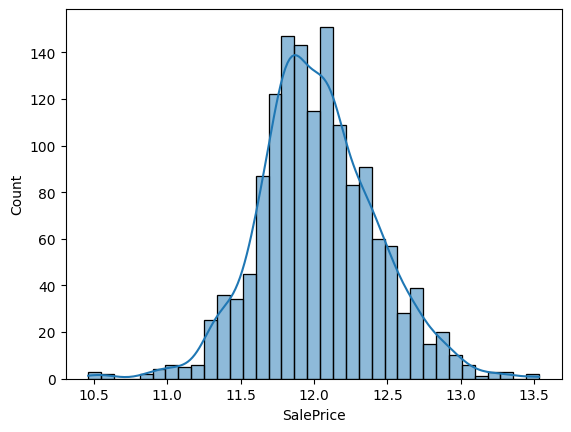

In [875]:
sns.histplot(data=y_trans, kde=True)

## Feature Engineer

In [876]:
len(X.columns)

79

We can create new features from the existing ones.

In [877]:
# Total square footage
X["TotalSF"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]

# Total number of bathrooms (full = 1, half = 0.5)
X["TotalBath"] = (
    X["FullBath"] + 0.5 * X["HalfBath"] + X["BsmtFullBath"] + 0.5 * X["BsmtHalfBath"]
)

# Age of the house at time of sale
X["Age"] = X["YrSold"] - X["YearBuilt"]

# Years since remodel
X["RemodAge"] = X["YrSold"] - X["YearRemodAdd"]

# Is remodeled
X["IsRemodeled"] = (X["YearBuilt"] != X["YearRemodAdd"]).astype(int)

We can drop redundant columns after creating new ones.

In [878]:
X.drop(
    columns=[
        "TotalBsmtSF",
        "1stFlrSF",
        "2ndFlrSF",
        "FullBath",
        "HalfBath",
        "BsmtFullBath",
        "BsmtHalfBath",
        "YrSold",
        "YearBuilt",
        "YearRemodAdd",
    ],
    inplace=True,
    errors="ignore",
)

In [879]:
len(X.columns)

74

Since feature engineering creates and drops columns, we need to infer the column types again.

In [880]:
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

## Handle Missing Values

We can easily impute missing values using the `SimpleImputer` from `sklearn.impute`. We will use the `median` strategy to impute numerical values and the `most_frequent` strategy to impute categorical values. However, based on the data description, there are some columns that treats `None` as a value. We will impute these columns with the `constant` strategy.

In [881]:
from house_prices_ml.config import NONE_FILL_COLS
NONE_FILL_COLS

['Alley',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [882]:
cat_fill_cols = [col for col in cat_cols if col not in NONE_FILL_COLS]
ct_impute = ColumnTransformer(
    [
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", SimpleImputer(strategy="most_frequent"), cat_fill_cols),
        ("none", SimpleImputer(strategy="constant", fill_value="None"), NONE_FILL_COLS),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")
X = ct_impute.fit_transform(X)
X.head(1)

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,...,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450.0,196.0,706.0,0.0,150.0,0.0,1710.0,3.0,1.0,...,GLQ,Unf,None,Attchd,RFn,TA,TA,None,None,None


In [883]:
# Test if there are still missing values
assert X.isnull().sum().sum() == 0

## Handle Outliers

Since boosting is robust to outliers, we can skip this for now.

## Handle Skewness

Trees are also robust to skewness. We can skip this for now.

## Encode Categorical

We can easily encode categorical features using the `OneHotEncoder` from `sklearn.preprocessing`. However, there are features that are better encoded as ordinal or frequency (high cardinality).

In [884]:
from house_prices_ml.config import ORDINAL_MAPPINGS
ORDINAL_MAPPINGS

{'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
 'LandSlope': ['Sev', 'Mod', 'Gtl'],
 'OverallQual': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
 'OverallCond': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
 'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
 'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],
 'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
 'G

In [885]:
ordinal_cols = list(ORDINAL_MAPPINGS.keys())
ordinal_categories = list(ORDINAL_MAPPINGS.values())
onehot_cols = list(set(cat_cols) - set(ordinal_cols))
# implement custom encoder for frequency encoding later in the pipeline

encoder = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), onehot_cols),
    ("ord", OrdinalEncoder(categories=ordinal_categories, handle_unknown="use_encoded_value", unknown_value=-1), ordinal_cols)
], remainder="passthrough", verbose_feature_names_out=False).set_output(transform="pandas")
X = encoder.fit_transform(X)
X.head(1)

,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,TotalSF,TotalBath,Age,RemodAge,IsRemodeled
Id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2566.0,3.5,5.0,5.0,0.0


## Scale Numerical

We can easily scale numerical featuresusing the `StandardScaler` from `sklearn.preprocessing`.

In [886]:
scaler = ColumnTransformer([
    ("num", StandardScaler(), num_cols)
], remainder="passthrough", verbose_feature_names_out=False).set_output(transform="pandas")
X = scaler.fit_transform(X)
X.head(1)

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,...,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,Functional,GarageFinish,PavedDrive,LotShape
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.220875,-0.207142,0.514104,0.575425,-0.288653,-0.944591,-0.120242,0.370333,0.163779,-0.211454,...,4.0,3.0,0.0,3.0,3.0,0.0,7.0,2.0,2.0,3.0


## Test Preprocessed Data

In [887]:
X

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,...,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,Functional,GarageFinish,PavedDrive,LotShape
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.220875,-0.207142,0.514104,0.575425,-0.288653,-0.944591,-0.120242,0.370333,0.163779,-0.211454,...,4.0,3.0,0.0,3.0,3.0,0.0,7.0,2.0,2.0,3.0
2,0.460320,-0.091886,-0.570750,1.171992,-0.288653,-0.641228,-0.120242,-0.482512,0.163779,-0.211454,...,4.0,2.0,3.0,3.0,3.0,0.0,7.0,2.0,2.0,3.0
3,-0.084636,0.073480,0.325915,0.092907,-0.288653,-0.301643,-0.120242,0.515013,0.163779,-0.211454,...,4.0,3.0,3.0,3.0,3.0,0.0,7.0,2.0,2.0,2.0
4,-0.447940,-0.096897,-0.570750,-0.499274,-0.288653,-0.061670,-0.120242,0.383659,0.163779,-0.211454,...,3.0,3.0,4.0,3.0,3.0,0.0,7.0,1.0,2.0,2.0
5,0.641972,0.375148,1.366489,0.463568,-0.288653,-0.174865,-0.120242,1.299326,1.390023,-0.211454,...,4.0,3.0,3.0,3.0,3.0,0.0,7.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,-0.357114,-0.260560,-0.570750,-0.973018,-0.288653,0.873321,-0.120242,0.250402,0.163779,-0.211454,...,4.0,2.0,3.0,3.0,3.0,0.0,7.0,2.0,2.0,3.0
1457,0.687385,0.266407,0.087911,0.759659,0.722112,0.049262,-0.120242,1.061367,0.163779,-0.211454,...,2.0,2.0,3.0,3.0,3.0,0.0,6.0,1.0,2.0,3.0
1458,-0.175462,-0.147810,-0.570750,-0.369871,-0.288653,0.701265,-0.120242,1.569647,1.390023,-0.211454,...,4.0,3.0,4.0,3.0,3.0,0.0,7.0,2.0,2.0,3.0


In [888]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Columns: 237 entries, LotFrontage to LotShape
dtypes: float64(237)
memory usage: 2.7 MB


In [889]:
with pd.option_context('display.max_columns', None):
    display(train.describe(include='all'))

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,588,1452.000000,1460,1460,1460,1423,1423,1422,1423,1460.000000,1422,1460.000000,1460.000000,1460.000000,1460,1460,1460,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,770,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,3,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,BrkFace,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,445,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.00000

## Test Final Preprocessor

In [890]:
train = pd.read_csv(RAW_DATA_DIR / 'train.csv', index_col='Id')
X = train.drop(TARGET, axis=1)
y = train[TARGET]

In [891]:
preprocessor = get_preprocessor()
preprocessor

,steps,"[('type_cast', ...), ('feat_eng', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,num_as_cat_cols,"['MSSubClass', 'OverallQual', ...]"
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [892]:
X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed = pd.DataFrame(X_preprocessed, columns=preprocessor.get_feature_names_out())
X_preprocessed

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,TotalSF,TotalBath,Age,RemodAge,IsRemodeled
Id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2566.0,3.5,5.0,5.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,2524.0,2.5,31.0,31.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9.0,2706.0,3.5,7.0,6.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2473.0,2.0,91.0,36.0,1.0
5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.0,3343.0,3.5,8.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,8.0,2600.0,2.5,8.0,7.0,1.0
1457,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,3615.0,3.0,32.0,22.0,1.0
1458,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2500.0,5.0,3492.0,2.0,69.0,4.0,1.0
